In [ ]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
from keras_tuner import RandomSearch
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
!ls /content/drive/MyDrive/ColabNotebooks/kaggle.json

/content/drive/MyDrive/ColabNotebooks/kaggle.json


In [ ]:
!cp /content/drive/MyDrive/ColabNotebooks/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 94% 139M/149M [00:00<00:00, 285MB/s]
100% 149M/149M [00:00<00:00, 267MB/s]


In [ ]:
!unzip brain-tumor-mri-dataset.zip -d ./brain_tumor_data

Streaming output truncated to the last 5000 lines.
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0712.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0713.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0714.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0715.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0716.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0717.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0718.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0719.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0720.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0721.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0722.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0723.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0724.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0725.jpg  
  inflating: ./brain_tumor_data/Trainin

In [ ]:
!ls ./brain_tumor_data

Testing  Training


In [ ]:
# Path ke dataset
train_dir = "./brain_tumor_data/Training"
test_dir = "./brain_tumor_data/Testing"

In [ ]:
def load_data():
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        image_size=(512, 512),
        batch_size=32
    )

    test_dataset = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        image_size=(512, 512),
        batch_size=32
    )

    # Use the map function to apply normalization to each image in the dataset
    train_dataset = train_dataset.map(lambda x, y: (x / 255.0, y))
    test_dataset = test_dataset.map(lambda x, y: (x / 255.0, y))

    return train_dataset, test_dataset

In [ ]:
# Main script
train_dataset, test_dataset = load_data()

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [ ]:
validation_dataset = test_dataset

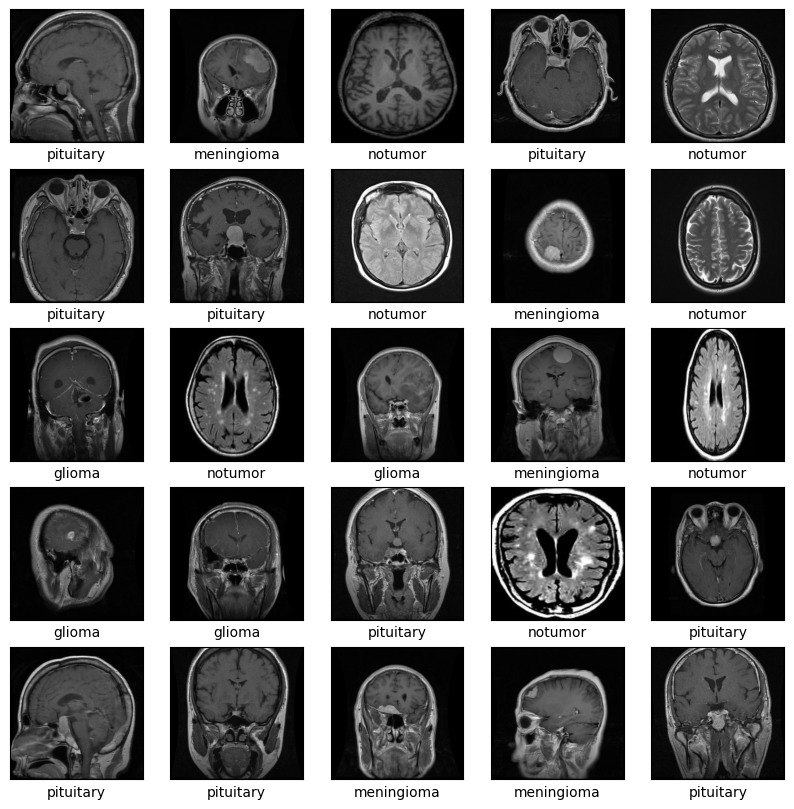

In [ ]:
# Ambil satu batch dari dataset
# Define class_names based on the folders in your training directory
import os
class_names = sorted(os.listdir(train_dir)) # Assuming train_dir is defined correctly

for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(25):  # Visualisasi 25 gambar pertama
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = images[i].numpy()

        # Skala ulang jika gambar dinormalisasi
        if img.max() <= 1:
            img = (img * 255).astype("uint8")

        plt.imshow(img)
        plt.xlabel(class_names[labels[i].numpy()]) # Now class_names is defined
    plt.show()

In [ ]:
# 2. Data augmentation
def create_data_generators():
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomTranslation(0.1, 0.1)
    ])
    return data_augmentation

In [ ]:
# 3. Define AlexNet model
def create_alexnet(input_shape):
    model = models.Sequential([
        layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((3, 3), strides=(2, 2)),
        layers.Conv2D(256, (5, 5), activation='relu', padding='same'),
        layers.MaxPooling2D((3, 3), strides=(2, 2)),
        layers.Conv2D(384, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(384, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((3, 3), strides=(2, 2)),
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    return model

In [ ]:
# 4. Define EfficientNetB3 model
def create_efficientnetb3(input_shape):
    base_model = EfficientNetB3(include_top=False, input_shape=input_shape, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    return model

In [ ]:
# 5. Hyperparameter tuning using KerasTuner
def build_model(hp):
    model = models.Sequential()
    model.add(layers.Conv2D(
        hp.Choice('units', [32, 64, 128]),
        kernel_size=(3, 3),
        activation='relu',
        input_shape=(512, 512, 3)
    ))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Int('dense_units', min_value=64, max_value=512, step=64), activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'sgd']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
def perform_tuning(train_dataset, validation_dataset): # Add validation_dataset as an argument
    tuner = RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=1,
        directory='tuner_dir',
        project_name='cnn_tuning'
    )
    # Use validation_data instead of validation_split
    tuner.search(train_dataset, epochs=10, validation_data=validation_dataset)
    return tuner

In [ ]:
data_augmentation = create_data_generators()

In [ ]:
# Augment train dataset
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
# Prepare datasets
input_shape = (512, 512, 3)

In [ ]:
# AlexNet
alexnet_model = create_alexnet(input_shape)
alexnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
alexnet_model.fit(train_dataset, epochs=10, validation_data=test_dataset)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 598s 3s/step - accuracy: 0.3488 - loss: 3.4008 - val_accuracy: 0.6629 - val_loss: 0.8545
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 532s 3s/step - accuracy: 0.6027 - loss: 0.9074 - val_accuracy: 0.6110 - val_loss: 0.9894
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 526s 3s/step - accuracy: 0.6912 - loss: 0.7676 - val_accuracy: 0.6400 - val_loss: 0.8470
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 518s 3s/step - accuracy: 0.7175 - loss: 0.7143 - val_accuracy: 0.7193 - val_loss: 0.6264
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 585s 3s/step - accuracy: 0.7417 - loss: 0.6576 - val_accuracy: 0.6880 - val_loss: 0.8204
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 533s 3s/step - accuracy: 0.7356 - loss: 0.6548 - val_accuracy: 0.7018 - val_loss: 0.6807
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 556s 3s/step - accuracy: 0.7612 - loss: 0.6033 - val_accuracy: 0.7292 - val_loss: 0.6845
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 566s 3s/step - accuracy: 0.7902 - loss: 0.5530 - val_accu

In [ ]:
# EfficientNetB3
efficientnet_model = create_efficientnetb3(input_shape)
efficientnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
efficientnet_model.fit(train_dataset, epochs=10, validation_data=test_dataset)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 685s 3s/step - accuracy: 0.2509 - loss: 1.6103 - val_accuracy: 0.3089 - val_loss: 1.3801
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 558s 3s/step - accuracy: 0.2521 - loss: 1.4316 - val_accuracy: 0.3089 - val_loss: 1.3781
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 565s 3s/step - accuracy: 0.2550 - loss: 1.4055 - val_accuracy: 0.3089 - val_loss: 1.3787
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 559s 3s/step - accuracy: 0.2495 - loss: 1.3967 - val_accuracy: 0.3089 - val_loss: 1.3778
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 551s 3s/step - accuracy: 0.2546 - loss: 1.3935 - val_accuracy: 0.3089 - val_loss: 1.3780
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 572s 3s/step - accuracy: 0.2513 - loss: 1.3933 - val_accuracy: 0.3089 - val_loss: 1.3777
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 562s 3s/step - accuracy: 0.2655 - loss: 1.3919 - val_accuracy: 0.3089 - val_loss: 1.3774
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 552s 3

In [ ]:
# Hyperparameter tuning
tuner = perform_tuning(train_dataset, validation_dataset)
best_hps = tuner.get_best_hyperparameters()[0]
print(f"Best Hyperparameters: {best_hps.values}")


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
32                |32                |units
64                |64                |dense_units
adam              |adam              |optimizer

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 546s 3s/step - accuracy: 0.3643 - loss: 7.2512 - val_accuracy: 0.5576 - val_loss: 1.0315
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 560s 3s/step - accuracy: 0.5839 - loss: 0.9533 - val_accuracy: 0.6354 - val_loss: 0.8834
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 524s 3s/step - accuracy: 0.6074 - loss: 0.8931 - val_accuracy: 0.5439 - val_loss: 1.0314
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 587s 3s/step - accuracy: 0.6317 - loss: 0.8442 - val_accuracy: 0.6369 - val_loss: 0.9653
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 603s 3s/step - accuracy: 0.6651 - loss: 0.8036 - val_accuracy: 0.6621 - val_loss: 0.8665
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 561s 3s/step - accuracy: 0.6809 - loss: 0.7739 - val_accuracy: 0.6911 - val_loss: 0.8237
Epo